In [ ]:
!pip install yfinance
!pip install yahooquery
!pip install tvdatafeed
!pip install tensorflow
!pip install mplfinance
!pip install cairocffi
from tvDatafeed import TvDatafeed, Interval
from yahooquery import Screener
import yfinance as yf   
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import random 
from tensorflow.keras.models import load_model
import os
import shutil
import mplfinance as mpl 
from datetime import datetime
import glob
from PIL import Image
import cv2
%matplotlib notebook
import gc
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('agg')
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation,Dropout,Flatten,Dense,AveragePooling2D,GlobalAveragePooling2D
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 7.6 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |███████████

In [ ]:
def work_with_dir():
  if os.path.exists("/content/data/"):
    shutil.rmtree("/content/data/", ignore_errors=True)
    print("Data Folder Removed")
    os.mkdir("/content/data/")
  if not os.path.exists("/content/data/"):
    os.mkdir("/content/data/")
  if not os.path.exists("/content/extracted/"):
    os.mkdir("/content/extracted/")
  if not os.path.exists("/content/checkpoints/"):
    os.mkdir("/content/checkpoints/")
def get_crypto_syms():
   screens = [
       'all_cryptocurrencies_us', 'all_cryptocurrencies_au', 'all_cryptocurrencies_ca', 'all_cryptocurrencies_eu', 'all_cryptocurrencies_gb', 'all_cryptocurrencies_in', ]
   s = Screener()
   symbols = []
   for i in screens:
      data = s.get_screeners(i, count=250)
      dicts = data[i]['quotes']
      syms = [d['symbol'] for d in dicts]
      for sym in syms:
        symbols.append(sym)
   return symbols
def download_data(symbols, periodd, intervall):
  indexx = 100
  work_with_dir()
  for symbol in symbols:
    if ((symbols.index(symbol)+1) % 100 == 0):
      print(f" -- {indexx}", end="")
      indexx = indexx + 100
    try:
        data = yf.download(symbol, period=periodd,
                           interval=intervall, progress=False, show_errors=False)
        if data.empty:
           pass
        else:
            data.to_csv(f"/content/data/{symbol}.csv")
    except:
       print("Error!")
  print(" ")
def extract_data(how_many_future_candles, how_many_past_candles, each_row_past):
  print(f"Files In Data : {len(os.listdir('/content/data/'))}")
  pd.options.mode.chained_assignment = None
  files = os.listdir("/content/data/")
  print("Processing File:")
  now = datetime.now().strftime("%H%M%S")
  os.mkdir(f"/content/extracted/{now}/")
  index = 1
  for file in files:
     print(f"File Number {index}:", end=" ")
     each_file_proc(file, now, how_many_future_candles,
                    how_many_past_candles, each_row_past)
     index = index + 1
  print(" ")
  return now
def each_file_proc(file, now, how_many_future_candles, how_many_past_candles, each_row_past):
    address = f"/content/data/{file}"
    data = pd.read_csv(address)
    if len(data.columns) == 7:
      data = data.iloc[:, 1:]
    data = np.array(data)
    data = data.astype(float)
    max_index = data.shape[0]-which_future_or_past
    for i in range(each_row_past,max_index):
        rows = data[i-each_row_past:i, :]

        next_candles = []
        for z in range(0, how_many_future_candles):
          next_candles.append(data[i+z][3]-data[i+z][0])
        next_candles = sum(next_candles)
        if next_candles > 0:
          sugg = 1
        else:
          sugg = 0

        df = pd.DataFrame(rows, columns=["Open", "High", "Low", "Close","Adj Close","Volume"])

        df.index.name = "Date"

        df.index = pd.to_datetime(df.index)
        right_now = datetime.now().strftime("%H%M%S%f")
        address = f"/content/extracted/{now}/{right_now}_{sugg}.png"
        

        fig, _a = mpl.plot(df, type="candle", style="yahoo", axisoff=True,
                            returnfig=True, tight_layout=True,figsize =(1.5,1.5))
        
        fig.savefig(address)
        fig.clf()

        if i % 10 == 0:
            print(f"{i}/{max_index}", end=" ")
        if i % 20:
          plt.close("all")
        if i % 270 ==0:
          print("")
    plt.close("all")
    print("")

def start(how_many_future_candles, how_many_past_candles, each_row_past):
    folder_name = extract_data(
        how_many_future_candles, how_many_past_candles, each_row_past)
    return folder_name

In [16]:
symbols = get_crypto_syms()
print(f"Symbols : {len(symbols)}")
symbols = ["btc-usd","eth-usd","trx-usd","ltc-usd","xrp-usd","bnb-usd"]
download_data(symbols,"15d","1h")

Symbols : 1500
Data Folder Removed
 


In [17]:
how_many_future_candles = 15
how_many_past_candles = 1
each_row_past = 85


global which_future_or_past
which_future_or_past = None
if how_many_future_candles > how_many_past_candles:
    which_future_or_past = how_many_future_candles
else:
    which_future_or_past = how_many_past_candles
folder_name = start(how_many_future_candles,how_many_past_candles,each_row_past)
len(os.listdir(f"/content/extracted/{folder_name}"))

Files In Data : 6
Processing File:
File Number 1: 90/333 100/333 110/333 120/333 130/333 140/333 150/333 160/333 170/333 180/333 190/333 200/333 210/333 220/333 230/333 240/333 250/333 260/333 270/333 
280/333 290/333 300/333 310/333 320/333 330/333 
File Number 2: 90/333 100/333 110/333 120/333 130/333 140/333 150/333 160/333 170/333 180/333 190/333 200/333 210/333 220/333 230/333 240/333 250/333 260/333 270/333 
280/333 290/333 300/333 310/333 320/333 330/333 
File Number 3: 90/333 100/333 110/333 120/333 130/333 140/333 150/333 160/333 170/333 180/333 190/333 200/333 210/333 220/333 230/333 240/333 250/333 260/333 270/333 
280/333 290/333 300/333 310/333 320/333 330/333 
File Number 4: 90/333 100/333 110/333 120/333 130/333 140/333 150/333 160/333 170/333 180/333 190/333 200/333 210/333 220/333 230/333 240/333 250/333 260/333 270/333 
280/333 290/333 300/333 310/333 320/333 330/333 
File Number 5: 90/333 100/333 110/333 120/333 130/333 140/333 150/333 160/333 170/333 180/333 190/333

1488

In [18]:
#folder_name = "165913"

shutil.make_archive(folder_name,"zip",f"/content/extracted/{folder_name}/")
#shutil.unpack_archive(f"/content/{folder_name}.zip",f"/content/extracted/{folder_name}")
label = []
data  = []
files = os.listdir(f"/content/extracted/{folder_name}/")
for i, image_name in enumerate(files):
  if image_name.split(".")[1] == "png":
    image = cv2.imread(f"/content/extracted/{folder_name}"+"/"+image_name,0)
    dim = (128, 128)
    resized = cv2.resize(image, dim)
    data.append(np.array(resized))
    sugg = image_name.split("_")[1].split(".")[0]
    label.append(int(sugg))
data = np.array(data)
data = data / 255
print(data.shape)
xTrain , xTest , yTrain , yTest = train_test_split(data,label,test_size=0.2,random_state=99)
data = None
label = None
print(f"xTrain : {len(xTrain)} \\ xTest : {len(xTest)}")
nytrain = []
nytest = []
yn = 0
nn = 0
for i in yTrain:
  if i == 1:
    nytrain.append([1,0])
    yn += 1
  else:
    nytrain.append([0,1])
    nn += 1
for i in yTest:
  if i == 1:
    nytest.append([1,0])
    yn += 1
  else:
    nytest.append([0,1])
    nn += 1
yTrain = np.array(nytrain)
yTest = np.array(nytest)
print(f"yn: {yn} nn: {nn}")

(1488, 128, 128)
xTrain : 1190 \ xTest : 298
yn: 729 nn: 759


In [ ]:
model.evaluate(xTest,yTest)

In [29]:
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(64,   (3, 3),activation="relu", input_shape=(xTrain.shape[1], xTrain.shape[2],1), kernel_regularizer=l2(0.00005), bias_regularizer=l2(0.00005)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(100,   (3,3),activation="relu", kernel_regularizer=l2(0.00005), bias_regularizer=l2(0.00005))) 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64,    (3,3),activation="relu", kernel_regularizer=l2(0.00005), bias_regularizer=l2(0.00005))) 
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Conv2D(32,    (3,3),activation="relu", kernel_regularizer=l2(0.00005), bias_regularizer=l2(0.00005))) 

model.add(Flatten())
model.add(Dense(512,activation="relu", kernel_regularizer=l2(0.00005), bias_regularizer=l2(0.00005)))
model.add(Dropout(0.1))
model.add(Dense(512,activation="relu", kernel_regularizer=l2(0.00005), bias_regularizer=l2(0.00005)))
model.add(Dropout(0.1))
model.add(Dense(512,activation="relu", kernel_regularizer=l2(0.00005), bias_regularizer=l2(0.00005)))
model.add(Dropout(0.1))
model.add(Dense(512,activation="relu", kernel_regularizer=l2(0.00005), bias_regularizer=l2(0.00005)))
model.add(Dense(2,activation="sigmoid"))

adamax = tf.keras.optimizers.Adamax(
    learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=adamax,
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 126, 126, 64)      640       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 63, 63, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 61, 61, 100)       57700     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 30, 30, 100)      0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 28, 28, 64)        57664     
                                                                 
 average_pooling2d_4 (Averag  (None, 14, 14, 64)      

In [30]:
filepath = "/content/checkpoints/{epoch:02d}-{val_accuracy:.2f}.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#model.fit(xTrain,yTrain,batch_size=64,epochs=30,validation_data=(xTest,yTest), callbacks=model_checkpoint_callback)
model.fit(xTrain,yTrain,batch_size=32,epochs=20,validation_data=(xTest,yTest))

Epoch 1/20
38/38 [==============================] - 72s 2s/step - loss: 0.7910 - accuracy: 0.4992 - val_loss: 0.7720 - val_accuracy: 0.4631
Epoch 2/20
38/38 [==============================] - 69s 2s/step - loss: 0.7633 - accuracy: 0.5218 - val_loss: 0.7619 - val_accuracy: 0.4631
Epoch 3/20
38/38 [==============================] - 73s 2s/step - loss: 0.7082 - accuracy: 0.6050 - val_loss: 0.6217 - val_accuracy: 0.7517
Epoch 4/20
38/38 [==============================] - 66s 2s/step - loss: 0.5241 - accuracy: 0.7866 - val_loss: 0.4680 - val_accuracy: 0.8087
Epoch 5/20
38/38 [==============================] - 67s 2s/step - loss: 0.4338 - accuracy: 0.8277 - val_loss: 0.4327 - val_accuracy: 0.8221
Epoch 6/20
38/38 [==============================] - 67s 2s/step - loss: 0.3693 - accuracy: 0.8588 - val_loss: 0.3554 - val_accuracy: 0.9094
Epoch 7/20
38/38 [==============================] - 66s 2s/step - loss: 0.3246 - accuracy: 0.8773 - val_loss: 0.3234 - val_accuracy: 0.8893
Epoch 8/20
38/38 [==

In [ ]:
model.save(f"1.h5")

[*********************100%***********************]  1 of 1 completed
                                   Open          High           Low  \
2022-07-13 00:00:00+00:00  19325.972656  19418.433594  19292.332031   
2022-07-13 01:00:00+00:00  19418.539062  19457.535156  19412.566406   
2022-07-13 02:00:00+00:00  19435.939453  19514.521484  19435.939453   
2022-07-13 03:00:00+00:00  19512.513672  19531.939453  19472.972656   
2022-07-13 04:00:00+00:00  19473.236328  19512.707031  19454.035156   
...                                 ...           ...           ...   
2022-08-01 08:00:00+00:00  23325.183594  23346.785156  23298.353516   
2022-08-01 09:00:00+00:00  23298.654297  23364.082031  23287.298828   
2022-08-01 10:00:00+00:00  23324.212891  23324.404297  23020.435547   
2022-08-01 11:00:00+00:00  23042.505859  23048.978516  23042.505859   
2022-08-01 11:05:00+00:00  23049.169922  23049.169922  23049.169922   

                                  Close     Adj Close     Volume  
2022-07-13 

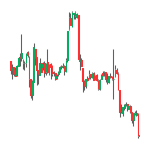

In [31]:
symbol,period,interval="btc-usd","20d","1h"
data = yf.download(tickers=symbol,period=period,interval=interval)
print(data)
data = np.array(data)
data = data.astype(float)
i = -1
rows = data[i-each_row_past:i, :]
df = pd.DataFrame(rows, columns=["Open", "High", "Low", "Close","Adj Close","Volume"])
df.index.name = "Date"
df.index = pd.to_datetime(df.index)
fig, _a = mpl.plot(df, type="candle", style="yahoo", axisoff=True,
                            returnfig=True, tight_layout=True,figsize =(1.5,1.5))
fig.savefig("picture.png")

In [32]:
image = cv2.imread("/content/picture.png",0)
dim = (128, 128)
resized = cv2.resize(image, dim)
data = np.array(resized)
model.predict([[data.reshape(1,128,128,1)]])

array([[0., 1.]], dtype=float32)

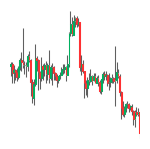

In [36]:
tv = TvDatafeed()
data = tv.get_hist(symbol="btcusdt",exchange="binance",interval=Interval.in_1_hour,n_bars=1000)
data = np.array(data)
i = -1
rows = data[i-each_row_past:i, 1:5]
rows.shape
df = pd.DataFrame(rows, columns=["Open", "High", "Low", "Close"])
df.index.name = "Date"
df.index = pd.to_datetime(df.index)
df = df.apply(lambda col:pd.to_numeric(col, errors='coerce'))
fig, _a = mpl.plot(df, type="candle", style="yahoo", axisoff=True,
                            returnfig=True, tight_layout=True,figsize =(1.5,1.5))
fig.savefig("picture1.png")

In [37]:
image = cv2.imread("/content/picture1.png",0)
dim = (128, 128)
resized = cv2.resize(image, dim)
data = np.array(resized)
model.predict([[data.reshape(1,128,128,1)]])

array([[0., 1.]], dtype=float32)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
lst = []
while True:
  ans = input()
  if ans == "exit":
    break
  lst.append(int(ans))
print(sum(max),len(lst))